# 调参教程
all2graph的模型参数主要分为四块：<br>
1、DataParser参数<br>
2、MetaInfo参数<br>
3、RawGraphParser参数<br>
4、网络结构参数<br>

我们从效果和使用两个角度来初步衡量一下参数的特性：<br>
1、在效果方面，4的影响最大，1其次，2和3的影响可能局限于数据集<br>
2、在使用方面，1的参数只能在DataParser构造的时候传入，2和3可以在构造Factory的时候传入，4可以在Factory.produce_model传入



In [1]:
import all2graph as ag
import pandas as pd
print(ag.__version__)

Using backend: pytorch


0.2.3


## 1. DataParser参数
这部分参数主要改变图结构

### 1.1 dict_dst_degree: 默认1，自然数，插入dict时跳连前置节点的度数，0表示全部
增大参数能增加图的复杂度，能提高拟合程度，同时增大内存占用，减慢训练速度

In [2]:
data1 = {'a': {'b': 'c'}}
df1 = pd.DataFrame({'timestamp': [None], 'data': [data1]})

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

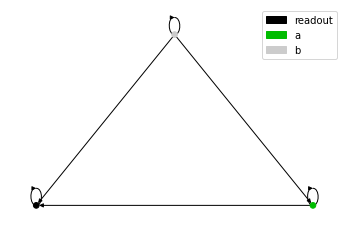

In [3]:
parser3 = ag.json.JsonParser(
    json_col='data',
    time_col='timestamp',
    dict_dst_degree=0
)
graph3 = parser3.parse(df1)[0]
graph3.draw()

### 1.2 list_dst_degree: 默认1，自然数，插入list时跳连前置节点的度数，0表示全部
增大参数能增加图的复杂度，能提高拟合程度，同时增大内存占用，减慢训练速度

In [4]:
data2 = {'a': [1, 2, 3]}
df2 = pd.DataFrame({'timestamp': [None], 'data': [data2]})

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

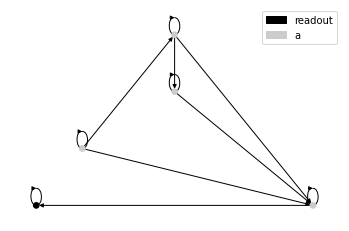

In [5]:
parser4 = ag.json.JsonParser(
    json_col='data',
    time_col='timestamp',
)
graph4 = parser4.parse(df2)[0]
graph4.draw()

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

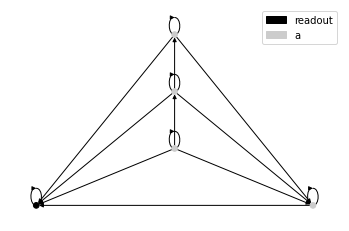

In [6]:
parser5 = ag.json.JsonParser(
    json_col='data',
    time_col='timestamp',
    list_dst_degree=0
)
graph5 = parser5.parse(df2)[0]
graph5.draw()

### 1.3 list_inner_degree: 默认1，list内部跳连后置节点的度数，0表示全部，-1表示没有
增大参数能增加图的复杂度，能提高拟合程度，同时增大内存占用，减慢训练速度

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

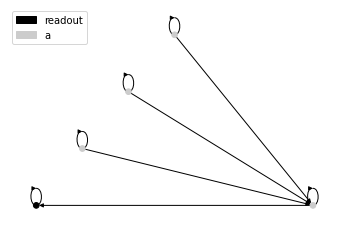

In [7]:
parser6 = ag.json.JsonParser(
    json_col='data',
    time_col='timestamp',
    list_inner_degree=0,
)
graph6 = parser6.parse(df2)[0]
graph6.draw()

### 1.4 r_list_inner_degree: 默认-1，list内部跳连前置节点的度数，0表示全部，-1表示没有
增大参数能增加图的复杂度，能提高拟合程度，同时增大内存占用，减慢训练速度

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

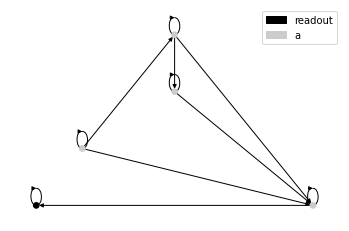

In [8]:
parser7 = ag.json.JsonParser(
    json_col='data',
    time_col='timestamp',
    r_list_inner_degree=0,
)
graph7 = parser7.parse(df2)[0]
graph7.draw()

### 1.5 self_loop: 默认True，添加自连接边
自连接能大大增强模型的表征能力

In [9]:
%%time
parser9 = ag.json.JsonParser(
    json_col='data',
    time_col='timestamp',
    self_loop=False
)
graph9 = parser9.parse(df1)[0]

Wall time: 0 ns


(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

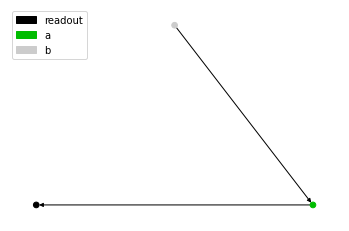

In [10]:
graph9.draw()

### 1.7 global_sequence: 默认False，将key相同的点前后串联起来
大大增强模型的表征能力，但是增加运算量和内存

In [11]:
import json
inputs = [{'a': [1, 2, 3]}, {'a': [4, 5]}]
inputs = pd.DataFrame([json.dumps(inputs)], columns=['data'])
inputs['timestamp'] = None

Wall time: 38.9 ms


(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

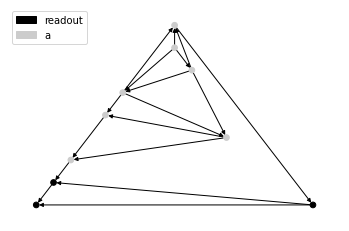

In [19]:
%%time
parser9 = ag.json.JsonParser(
    json_col='data',
    time_col='timestamp',
    self_loop=False,
    list_inner_degree=2,
    global_sequence=True,
)
graph9 = parser9.parse(inputs)[0]
graph9.draw()

In [20]:
graph9.to_df('key', 'value')

,src,dst,src_key,src_value,dst_key,dst_value
0,2,1,a,"[1, 2, 3]",readout,"{'a': [1, 2, 3]}"
1,3,2,a,1,a,"[1, 2, 3]"
2,4,2,a,2,a,"[1, 2, 3]"
3,5,2,a,3,a,"[1, 2, 3]"
4,3,4,a,1,a,2
5,3,5,a,1,a,3
6,4,5,a,2,a,3
7,7,6,a,"[4, 5]",readout,"{'a': [4, 5]}"
8,8,7,a,4,a,"[4, 5]"
9,9,7,a,5,a,"[4, 5]"


## 2. MetaInfo参数
这部分参数主要影响元数据，从而影响数据的归一化
### 2.1 num_bins: 统计数据分布时分箱的数量，默认None，即不分箱
数据的归一化是根据分布来进行的，减少分箱会1）降低分布精度；2）对数据进行截尾<br>
适当的分箱能增强模型的稳定性和泛化能力，但是过度的分箱会产生信息损失，从而造成模型效果下降

In [14]:
factory1 = ag.Factory(
    data_parser=parser4
)
meta_info1 = factory1.analyse(df2, processes=0)
meta_info1.meta_numbers['a'].value_ecdf.quantiles

1it [00:00, 77.03it/s, reading csv]
100%|################################################################################################################################################################################################################################################################| 1/1 [00:00<?, ?it/s, reducing meta numbers phase 2]
0it [00:00, ?it/s, reducing meta string]
100%|#################################################################################################################################################################################################################################################################| 2/2 [00:00<00:00, 2004.93it/s, reducing meta name]

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\cxt\AppData\Local\Temp\jieba.cache


Loading model cost 0.523 seconds.
Prefix dict has been built successfully.


array([1., 2., 3.])

In [15]:
factory2 = ag.Factory(
    data_parser=parser4,
    meta_info_config=dict(
        num_bins=2
    )
)
meta_info2 = factory2.analyse(df2, processes=0)
meta_info2.meta_numbers['a'].value_ecdf.quantiles

1it [00:00, 77.13it/s, reading csv]
100%|################################################################################################################################################################################################################################################################| 1/1 [00:00<?, ?it/s, reducing meta numbers phase 2]
0it [00:00, ?it/s, reducing meta string]
100%|#################################################################################################################################################################################################################################################################| 2/2 [00:00<00:00, 2005.40it/s, reducing meta name]


array([1., 2.])

## 3. RawGraphParser参数
这部分参数控制归一化和转化成dgl.Graph的流程
### 3.1 min_df: 字符串最小文档频率，小于这个值的字符串会被转换成None
### 3.2 max_df: 字符串最大文档频率，大于这个值的字符串会被转换成None
### 3.3 top_k:  选择前k个字符串，其他字符串都会被转化成None
### 3.4 top_method: 选择前k个字符串的排序方法，'max_tfidf', 'mean_tfidf', 'max_tf', 'mean_tf', 'max_tc', mean_tc'
### 3.5 scale_method: 'prob' or 'minmax_scale'
对数值型做归一化的方法，prob表示按照概率归一化，minmax_scale表示minmax归一化<br>
归一化所使用的分布和统计值，均来自MetaInfo，因此会受到MetaInfo参数的影响
### 3.6 clip: 当scale_method为'minmax_scale'时可以使用的参数，默认False
如果True，那么归一化的数值会被限制在0到1之间
clip能增强模型的稳定型，防止数值溢出的错误，但是也会损失部分信息，导致模型效果下降

In [16]:
factory3 = ag.Factory(
    data_parser=parser4,
    raw_graph_parser_config=dict(
        min_df=0.05,
        max_df=0.95,
        top_k=50,
        top_method='max_tf',
        scale_method='minmax_scale',
        scale_kwargs=dict(clip=True)
    )
)

## 4. 网络结构参数
参数有很多，建议先调大参数，再调小参数
### 4.1 d_model: 整数，模型隐藏层神经元数量
数值越大，模型表征能力越强，同时参数量按O(n^2)上升，计算时间按照O(n^3)上升
### 4.2 nhead：整数，而且必须是d_model的因数，注意力机head数量
数值越大，模型表征能力增强，参数量和计算量几乎不变
### 4.3 num_layers：整数数组，例如[1, 2, 3] ，数组长度表示模型block数量，每个数表示这个block里的隐藏层数
block越多，模型表征能力越强，参数量和计算量按照O(n)上升<br>
block内的隐藏层共享参数，因此只会增加计算量，几乎不会影响参数量，增大时能增加模型表征能力
### 4.4 encoder_config: 模型主干的小参数

#### 4.4.1 num_weight: 默认True, 连续性数据embedding成一个向量
#### 4.4.2 key_emb:  默认True，embedding每个点的类型
#### 4.4.3 num_activation: 默认'prelu', 连续性数据的激活层 
#### 4.4.4 dropout: float = 0.1,
#### 4.4.5 share_layer: bool = False,
#### 4.4.6 residual: bool = False, 建议False
#### 4.4.7 conv_config: dict = None,
##### 4.4.7.1 key_bias=True,
##### 4.4.7.2 key_norm=True,
##### 4.4.7.3 key_activation='prelu',
##### 4.4.7.4 value_bias=True,
##### 4.4.7.5 value_norm=True,
##### 4.4.7.6 value_activation='prelu',
##### 4.4.7.7 node_bias=True,
##### 4.4.7.8 node_activation='prelu',
##### 4.4.7.9 residual=True,
##### 4.4.7.10 norm=True
#### 4.4.8 output_config: dict = None
##### 4.4.8.1 last_block_only: 只使用最后一个block的特征
##### 4.4.8.2 last_layer_only: 只使用每个block最后一层的特征
##### 4.4.8.3 share_block_param: 同一个block公用
##### 4.4.8.4 bias: 是否使用bias
##### 4.4.8.5 hidden_layers: 隐藏层层数
##### 4.4.8.6 hidden_bias: 隐藏层bias
##### 4.4.8.7 activation:
#### 4.4.9 emb_config: dict，离散型数据embeding层的小参数，详见torch.nn.Embedding

In [17]:
model = factory1.produce_model(
    d_model=8,
    nhead=2,
    num_layers=[1, 1, 1],
    encoder_config=dict(
        dropout=0,
        conv_config=dict(
            residual=False
        ),
        output_config=dict(
            hidden_layers=2
        )
    )
)